In [ ]:
import pandas as pd
import re
import os
import random
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup, MarkupResemblesLocatorWarning
import jieba
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.model_selection as ms
from collections import Counter
import jieba.analyse
from wordcloud import WordCloud
import warnings
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
import requests
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
warnings.filterwarnings("ignore", category=UserWarning)

#数据加载
df = pd.read_csv("test.csv", encoding="gbk", header=None)
df.columns = ['comment']
df.head(10)

,comment
0,text
1,"移动偷走流量么?这个月各种省流量,结果充了一会电,发现流量少了600多,移动是后妈么,这么欺..."
2,回复@孟然:随行人员坚决反对我去云顶[泪] //@孟然:和筹码似的
3,@刘?-妞儿 ，上地址 //@菁制美食:没错！介绍了美食却死活不肯说地址！急死你！[抓狂]
4,是啊，图书刚要开机印刷，张悟本事件就出来了，顿时真个养生书市场一片低靡，那时确实是最困难的时...
5,[顶]当然要要回来。[怒骂]凭什么借钱的是大爷？？滚犊子。钱都是辛苦赚的。不是血花的天上飞下...
6,坏人们！[怒] //@刘展耘:同同?~ //@伍餐肉:同? //@心泉之家:@熊丽电台 @李...
7,哎不是好朋友又要麻烦人家帮忙就感特别抱歉一样的
8,"看资料一直看到把""入""写成""人""字的,""埋入""写成""埋人"",""穿入""写成""穿人""不能忍了看到..."
9,保护好自己. #抗击新型肺炎第一线# 致敬伟大的逆行者们 一定要平平安安《心》


In [ ]:
# 数据预处理 
# 文本清洗与分词  （清洗特定的格式）
# 全局定义停用词  （结合停用词表  自定义   停用词链接   集合）
weibo_stopwords = {
    "转发微博", "分享图片", "网页链接", "展开全文", "收起全文", "查看图片", 
    "原图", "转发", "评论", "赞", "微博", "微博客户端", "视频", "图片", "来自","回复","这么","今天","一个","自己",
    "起来","看看","时候", "嘿嘿", "呜呜", "吼吼", "哎", "哎哎", "哦", "哟", "啦", "呗", "嘞",
    "我们", "你们", "他们", "大家", "这个", "那个", "什么", "这样", "那样", "一起", "还有",
    "就是", "不是", "已经", "没有", "一下", "可以", "真的", "感觉", "现在",
    "给力", "馋嘴", "吃惊", "一次", "打卡", "路过", "飘过", "顶", "支持", "赞一个",
    "了", "的", "是", "在", "和", "就", "都", "也", "有", "我", "你", "他", "她", "它", "这", "那"}

def preprocess_text(df):
    """对DataFrame中的评论进行预处理"""
    #文本清洗
    df['cleaned_comment'] = df['comment'].astype(str)#类型
    df['cleaned_comment'] = df['cleaned_comment'].str.replace(r'#([^#]+)#', r' \1 ', regex=True)#提取话题标签内容
    df['cleaned_comment'] = df['cleaned_comment'].str.replace(r'\[([^\]]+)\]', r' \1 ', regex=True)#提取中括号内文本
    df['cleaned_comment'] = df['cleaned_comment'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())#html
    df['cleaned_comment'] = df['cleaned_comment'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)#链接
    df['cleaned_comment'] = df['cleaned_comment'].str.replace(r'@[^:：\s]+[:：]?', '', regex=True)#提及部分
    df['cleaned_comment'] = df['cleaned_comment'].str.replace(r'\[.*?\]|【.*?】|\(.*?\)', '', regex=True)#移除特殊符号内文本
    df['cleaned_comment'] = df['cleaned_comment'].str.replace(r'[^\w\s\u4e00-\u9fa5#@，。！？、；：,.!?;:\'\"]', ' ', regex=True)#字符过滤
    df['cleaned_comment'] = df['cleaned_comment'].str.replace(r'\s+', ' ', regex=True).str.strip()#空格
    df['cleaned_comment'] = df['cleaned_comment'].str.lower()#小写
    
    #停用词表
    try:
        hhit_stopwords_url = "https://raw.githubusercontent.com/letsgochina/ChineseStopWords/master/hit_stopwords.txt"
        response = requests.get(hhit_stopwords_url)
        hhit_stopwords = set(response.text.split()) if response.status_code == 200 else set()
    except:
        hhit_stopwords = set()
    
    global WEIBO_STOPWORDS
    WEIBO_STOPWORDS = list(hhit_stopwords | weibo_stopwords)
    
    # 分词并过滤停用词
    df['cleaned_comment'] = df['cleaned_comment'].apply(lambda x: jieba.lcut(x))
    df['cleaned_comment'] = df['cleaned_comment'].apply(lambda tokens: 
        " ".join([token.strip() for token in tokens 
                  if token.strip() not in WEIBO_STOPWORDS and len(token.strip()) > 1]))
    
    # 移除空评论
    df = df[df['cleaned_comment'].str.strip() != ""]
    return df

# 应用预处理函数到训练数据
df = preprocess_text(df)

# 计算词频
corpus = df['cleaned_comment'].tolist()
word_freq = {}
total_docs = len(corpus)

for text in corpus:
    words = set(text.split())
    for word in words:
        word_freq[word] = word_freq.get(word, 0) + 1 #(文档频率 提高普通降低稀有词)

for word in word_freq:
    word_freq[word] /= total_docs

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86157\AppData\Local\Temp\jieba.cache
Loading model cost 0.454 seconds.
Prefix dict has been built successfully.


In [ ]:

#测试集
test_df = pd.read_csv("test.mark1.csv", encoding="gb18030")
#训练集
train_df = df.copy()
# 打印数据集信息
print(f"训练集样本数: {len(train_df)}")
print(f"测试集样本数: {len(test_df)}")
print("\n测试集标签分布:")
print(f"正面评论(sentiment=1): {sum(test_df['sentiment']==1)}条")
print(f"负面评论(sentiment=0): {sum(test_df['sentiment']==0)}条")

训练集样本数: 9948
测试集样本数: 3622

测试集标签分布:
正面评论(sentiment=1): 1678条
负面评论(sentiment=0): 1944条


In [ ]:
#建模与分类

# Word2Vec 相似度和 TF-IDF 值双重筛选  自适应阈值    平均 TF-IDF 用于关键词筛选 ◦ IDF 值用于分类加权 ◦ 最大化利用 TF-IDF 的多维度信息   匹配度低>>其他
# 计算训练集词频
corpus = train_df['cleaned_comment'].tolist()
word_freq = {}
total_docs = len(corpus)

for text in corpus:
    words = set(text.split())
    for word in words:
        word_freq[word] = word_freq.get(word, 0) + 1

for word in word_freq:
    word_freq[word] /= total_docs

#训练Word2Vec
sentences = [text.split() for text in corpus]
model = Word2Vec(
    sentences,
    vector_size=50,        # 向量维度
    window=4,              # 窗口大小
    min_count=4,           # 最小词频阈值
    workers=os.cpu_count(),# 自动使用所有CPU核心
    sg=1,                  # 使用Skip-gram模型
    hs=0,                  # 启用负采样
    negative=5,            # 负采样数
    epochs=4               # 训练轮数
)

#计算训练集TF-IDF
vectorizer = TfidfVectorizer(max_df=0.7, min_df=2)
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
tfidf_avg_dict = {}
for i, word in enumerate(feature_names):
    tfidf_avg_dict[word] = np.mean(tfidf_matrix[:, i].toarray())

#定义关键词
seed_keywords = {
    "饮食": ["米饭", "饮食", "面条", "火锅", "奶茶", "烹饪", "食材", "餐厅", "美食", "早餐", 
            "晚餐", "饭店", "点心", "蛋糕", "菜", "味道", "菜谱", "菜系", "茶", "烧烤", 
            "品尝", "吃", "口感", "厨艺", "外卖", "烤箱", "烘焙", "甜品","煲汤","好吃"],
    "娱乐": ["电影", "明星", "演唱会", "综艺", "追剧", "票房", "演员", "歌手", "音乐", "游戏",
            "专辑", "唱片", "台词", "粉丝", "球迷", "卫视", "节目", "花絮", "剧情", "导演",
            "艺人", "韩剧", "美剧", "话剧", "小说","足球","乒乓"],
    "旅游": ["旅游", "玩", "景点", "旅行", "旅馆", "大理", "酒店", "风景", "打卡", "目的地",
            "签证", "护照", "旅客", "导游", "机票", "车票", "民宿", "门票"],
    "社会": ["抗议", "政策", "民生", "公平", "事件", "新闻", "政府", "问题", "调查", "报道",
            "媒体", "改革", "社会", "游行", "示威", "罢工", "国家"],
    "交通出行": ["公交", "地铁", "机场", "火车", "大巴", "高铁", "车位", "通勤", "交通", "停车",
                "航班", "车次", "轮船", "动车", "铁路", "车祸", "追尾", "步行", "brt", "飞机","打车"],
    "购物": ["买","卖","免税","超市", "购买", "购物", "砍价", "抢购", "发货", "退货", "换货", "退款", "商场",
            "满减", "拼单", "逛街", "优惠", "电商", "淘宝", "京东", "消费","商家","会员","团购"],
    "科技": ["芯片", "AI", "元宇宙", "互联网", "技术", "创新", "研发", "智能", "数据",
            "半导体", "专利", "高新", "科研", "智能", "手环", "智慧", "现代化", "ai"],
    "安全": ["诈骗", "风险", "警惕", "防盗", "防骗", "陷阱", "欺诈", "钓鱼", "盗刷",
            "受伤", "事故", "火灾", "爆炸", "毒品", "犯罪", "枪击", "案件","拘留","公安","依法","刑法"],
    "医疗": ["疫情", "医护人员", "防护", "隔离", "前线", "致敬", "平安健康", "护士", "诊断",
            "三甲", "医疗", "核酸", "门诊", "住院", "挂号", "医院", "医生", "疫苗", "体检",
            "传染", "病", "发烧", "医疗", "医保", "确诊", "新冠", "肺炎", "输液"],
    "时尚美妆": ["时尚", "美妆", "穿搭", "搭配", "护肤", "口红", "粉底", "面膜", "香水",
                "发型", "造型", "街拍", "彩妆", "防晒", "配饰", "美颜", "妆容", "卸妆",
                "时装周", "美容仪"],
    "教育": ["学校", "老师", "学生", "学习", "考试", "作业", "大学", "课程", "培训",
            "教育政策", "学习", "小学", "初中", "高中", "看书", "书", "教育", "教学", "学历"],
    "情感": ["爱情", "友情", "家庭", "心情", "压力", "孤独", "快乐", "焦虑", "人际关系",
            "开心", "伤心", "发飙", "生气", "难过", "怒", "发怒", "哭泣", "哭", "烦",
            "haha", "HAHA", "放松", "感激", "感谢", "烦恼", "幸福", "郁闷"],
    "工作": ["工资", "工作", "上班", "老板", "公司", "上司", "上班", "下班", "加班", "面试",
            "辞职", "职场", "离职", "企业", "办公室"],
    "生活": ["生活", "日常","回家", "煮饭", "家务", "洗衣服", "宠物", "猫", "狗", "厨房", "卧室",
            "客厅", "烹饪", "居家", "家具", "冰箱", "浴室", "邻居", "舍友", "室友",
            "睡觉", "休息","闹钟", "累"],
    "环境": ["环保", "环境", "水资源", "污染", "空气", "地震", "自然", "森林", "草原",
            "节能", "风电", "水电", "火电", "核能", "生态", "濒危", "公益", "排污"]
}

#扩展关键词
all_seeds = set()
for seeds in seed_keywords.values():
    all_seeds.update(seeds)

seed_similars = {}
for seed in all_seeds:
    if seed in model.wv:
        seed_similars[seed] = model.wv.most_similar(seed, topn=3)

expanded_keywords = {}
for topic, seeds in seed_keywords.items():
    related_words = set(seeds)
    for seed in seeds:
        if seed in seed_similars:
            for word, sim in seed_similars[seed]:
                freq = word_freq.get(word, 0)
                if freq < 0.005:
                    adjusted_threshold = max(0.45, 0.55 - 0.1)
                elif freq > 0.05:
                    adjusted_threshold = min(0.7, 0.55 + 0.1)
                else:
                    adjusted_threshold = 0.55
                
                # 确保使用全局定义的weibo_stopwords
                if sim >= adjusted_threshold and word not in weibo_stopwords:
                    if tfidf_avg_dict.get(word, 0) > 0.2 or sim >= adjusted_threshold + 0.05:
                        related_words.add(word)
    expanded_keywords[topic] = list(related_words)

#关键词到主题的映射
word_to_topic = {}
for topic, keywords in expanded_keywords.items():
    for word in keywords:
        word_to_topic[word] = topic

#重新计算训练集TF-IDF用于分类
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2)
tfidf_matrix = vectorizer.fit_transform(train_df['cleaned_comment'])
feature_names = vectorizer.get_feature_names_out()
tfidf_idf_dict = {}
for i, word in enumerate(feature_names):
    tfidf_idf_dict[word] = vectorizer.idf_[i]

#文本分类函数
def classify_text(text):
    scores = {topic: 0 for topic in set(word_to_topic.values())}
    scores["其他"] = 0
    
    for word in text.split():
        if word in word_to_topic:
            topic = word_to_topic[word]
            weight = tfidf_idf_dict.get(word, 1.0)
            scores[topic] += 1 * weight
    
    max_score = max(scores.values())
    return max(scores, key=scores.get) if max_score >= 1.5 else "其他"

#对训练集执行分类
train_df['topic'] = Parallel(n_jobs=-1)(
    delayed(classify_text)(text) for text in train_df['cleaned_comment']
)

#输出训练集分类结果统计
print("\n训练集分类结果统计:")
train_topic_counts = train_df['topic'].value_counts()
for topic, count in train_topic_counts.items():
    print(f"{topic}: {count}条 ({count/len(train_df):.2%})")



训练集分类结果统计:
其他: 3149条 (31.65%)
情感: 1444条 (14.52%)
饮食: 925条 (9.30%)
生活: 683条 (6.87%)
娱乐: 484条 (4.87%)
教育: 480条 (4.83%)
工作: 427条 (4.29%)
医疗: 405条 (4.07%)
交通出行: 366条 (3.68%)
社会: 329条 (3.31%)
旅游: 313条 (3.15%)
购物: 277条 (2.78%)
环境: 273条 (2.74%)
时尚美妆: 179条 (1.80%)
科技: 121条 (1.22%)
安全: 93条 (0.93%)


In [ ]:
#动态获取 CPU 核心数 提高效率     空文本>>其他
MAX_JOBS = os.cpu_count() 

def classify_text(text):
    """使用训练好的模型对文本进行分类"""
    if not text.strip():
        return "其他"
    
    scores = {topic: 0 for topic in set(word_to_topic.values())}
    scores["其他"] = 0
    
    for word in text.split():
        if word in word_to_topic:
            topic = word_to_topic[word]
            weight = tfidf_idf_dict.get(word, 1.0)
            scores[topic] += 1 * weight
    
    return max(scores, key=scores.get) if max(scores.values()) >= 1.5 else "其他"

def preprocess_test_data(test_df):
    """对测试数据执行预处理"""
    test_df['cleaned_comment'] = test_df['comment'].astype(str)
    
    #批量文本清洗
    test_df['cleaned_comment'] = test_df['cleaned_comment'].str.replace(r'#([^#]+)#', r' \1 ', regex=True)
    test_df['cleaned_comment'] = test_df['cleaned_comment'].str.replace(r'\[([^\]]+)\]', r' \1 ', regex=True)
    test_df['cleaned_comment'] = test_df['cleaned_comment'].apply(
        lambda x: BeautifulSoup(x, 'html.parser').get_text() if pd.notna(x) else ""
    )
    test_df['cleaned_comment'] = test_df['cleaned_comment'].str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    test_df['cleaned_comment'] = test_df['cleaned_comment'].str.replace(r'@[^:：\s]+[:：]?', '', regex=True)
    test_df['cleaned_comment'] = test_df['cleaned_comment'].str.replace(r'[^\w\s\u4e00-\u9fa5]', ' ', regex=True)
    test_df['cleaned_comment'] = test_df['cleaned_comment'].str.replace(r'\s+', ' ', regex=True).str.strip()
    test_df['cleaned_comment'] = test_df['cleaned_comment'].str.lower()
    
    #加载停用词表
    try:
        hhit_stopwords = set(requests.get(
            "https://raw.githubusercontent.com/letsgochina/ChineseStopWords/master/hit_stopwords.txt", 
            timeout=5
        ).text.split())
    except:
        hhit_stopwords = set()
    
    weibo_stopwords = {
        "转发微博", "分享图片", "网页链接", "展开全文", "收起全文", "查看图片", 
        "原图", "转发", "评论", "赞", "微博", "微博客户端", "视频", "图片", "来自",
        "回复", "我们", "你们", "他们", "这个", "那个", "什么", "就是", "不是", "已经",
        "没有", "可以", "真的", "感觉", "现在", "了", "的", "是", "在", "和", "就", "都",
        "也", "有", "我", "你", "他", "她", "它", "这", "那"
    }
    
    # 分词并过滤停用词
    stopwords = hhit_stopwords | weibo_stopwords
    test_df['cleaned_comment'] = test_df['cleaned_comment'].apply(
        lambda x: jieba.lcut(x) if pd.notna(x) else []
    )
    test_df['cleaned_comment'] = test_df['cleaned_comment'].apply(
        lambda tokens: " ".join([t for t in tokens if t not in stopwords and len(t) > 1])
    )
    
    return test_df

#预处理测试数据
test_df = preprocess_test_data(test_df)

#执行分类
test_df['predicted_topic'] = Parallel(n_jobs=MAX_JOBS, prefer='threads')(
    delayed(classify_text)(text) for text in test_df['cleaned_comment']
)

#输出分类结果统计
print("\n测试集分类结果统计:")
test_topic_counts = test_df['predicted_topic'].value_counts()
for topic, count in test_topic_counts.items():
    print(f"{topic}: {count}条 ({count/len(test_df):.2%})")

#计算评估指标
if 'topic' in test_df.columns:  #自动跳过无标注数据
    labeled_test_df = test_df[test_df['topic'].notna()].copy()
    if not labeled_test_df.empty:
        print("\n模型评估报告:")
        print(classification_report(
            labeled_test_df['topic'],
            labeled_test_df['predicted_topic'],
            zero_division=0
        ))


测试集分类结果统计:
其他: 1183条 (32.66%)
情感: 490条 (13.53%)
饮食: 303条 (8.37%)
生活: 255条 (7.04%)
教育: 194条 (5.36%)
娱乐: 180条 (4.97%)
工作: 161条 (4.45%)
医疗: 156条 (4.31%)
旅游: 134条 (3.70%)
交通出行: 123条 (3.40%)
社会: 111条 (3.06%)
环境: 109条 (3.01%)
购物: 83条 (2.29%)
时尚美妆: 66条 (1.82%)
科技: 39条 (1.08%)
安全: 35条 (0.97%)

模型评估报告:
              precision    recall  f1-score   support

        交通出行       0.67      0.44      0.53         9
          其他       0.00      0.00      0.00         0
          医疗       0.70      1.00      0.82        16
          娱乐       0.69      0.79      0.73        14
          安全       0.80      0.44      0.57         9
          工作       0.82      0.75      0.78        12
          情感       0.71      0.41      0.52        29
          教育       0.36      0.80      0.50         5
          旅游       0.67      0.50      0.57        12
        时尚美妆       0.57      0.40      0.47        10
          环境       1.00      0.50      0.67         8
          生活       0.60      0.82      0.69        11
 

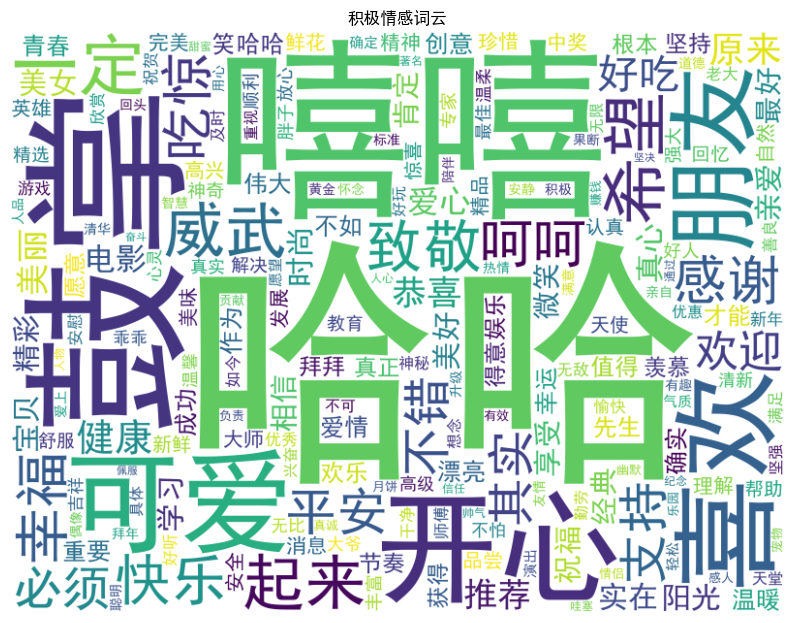

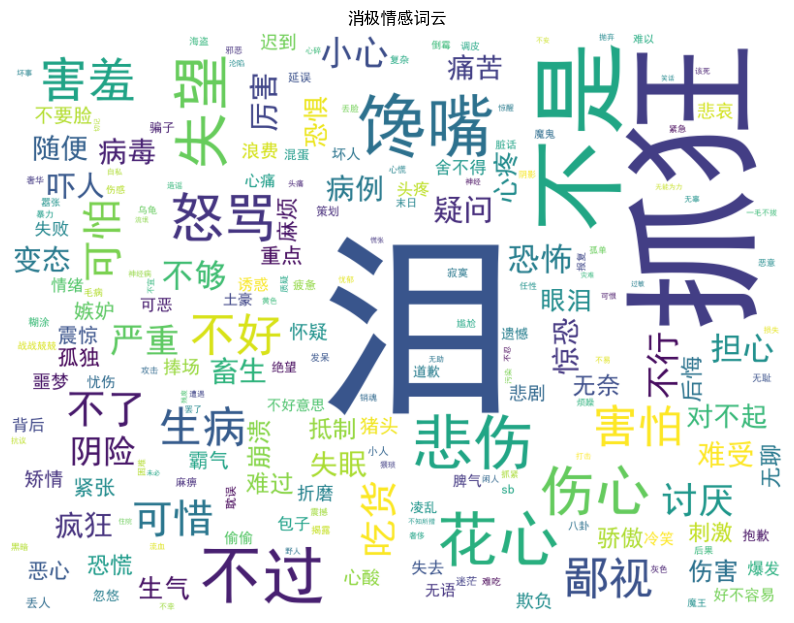

情感聚类轮廓系数: 0.8430


In [ ]:
#设置中文字体支持
#检验  避免空文本导致的除零错误  小样本导致的聚类失效  无情感词时的无效可视化
#与无监督聚类结合
#自适应维度降维
plt.rcParams["font.family"] = ["SimHei"]

class DalianSentimentAnalyzer:
    def __init__(self, dict_path='大连理工情感词典.xlsx'):
        self.positive_words = set()
        self.negative_words = set()
        self.positive_scores = {}
        self.negative_scores = {}
        if os.path.exists(dict_path):
            self._load_dictionary(dict_path)

    def _load_dictionary(self, dict_path):
        df = pd.read_excel(dict_path)
        for _, row in df.iterrows():
            word = str(row['词语']).strip()
            emotion_type = str(row['情感分类']).strip()
            polarity = int(row['极性'])
            intensity = float(row['强度'])
            if emotion_type.startswith('P') or polarity == 1:
                self.positive_words.add(word)
                self.positive_scores[word] = intensity
            elif emotion_type.startswith('N') or polarity == 2:
                self.negative_words.add(word)
                self.negative_scores[word] = intensity

    def analyze(self, text):
        words = jieba.lcut(text)
        positive_score = sum(self.positive_scores.get(word, 0) for word in words if word in self.positive_scores)
        negative_score = sum(self.negative_scores.get(word, 0) for word in words if word in self.negative_scores)
        total_score = positive_score - negative_score
        word_count = len(words)
        return (total_score / word_count, word_count) if word_count > 0 else (0, 0)

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s\u4e00-\u9fa5]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_sentiment_features(df, text_column='cleaned_comment'):
    analyzer = DalianSentimentAnalyzer()
    features = []
    for text in df[text_column].dropna():
        words = jieba.lcut(text)
        pos_count = sum(1 for word in words if word in analyzer.positive_words)
        neg_count = sum(1 for word in words if word in analyzer.negative_words)
        total_words = len(words)
        
        if total_words > 0:
            pos_ratio = pos_count / total_words
            neg_ratio = neg_count / total_words
            
            total_score, _ = analyzer.analyze(text)
            word_freq = total_words / 100
            pos_neg_ratio = pos_ratio / (neg_ratio + 1e-6)
            
            features.append([
                pos_ratio, neg_ratio, total_score, 
                word_freq, pos_neg_ratio
            ])
    return np.array(features)

def optimize_clusters(X, max_clusters=10):
    if len(X) < 2:
        return -1
    
    pca = PCA(n_components=min(3, X.shape[1]))
    X_pca = pca.fit_transform(X)
    
    kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, labels)
    return silhouette_avg

def analyze_all_texts(df, text_column='cleaned_comment'):
    analyzer = DalianSentimentAnalyzer()
    positive_words, negative_words = [], []
    for text in df[text_column].dropna():
        words = jieba.lcut(text)
        for word in words:
            if word in analyzer.positive_words:
                positive_words.append(word)
            elif word in analyzer.negative_words:
                negative_words.append(word)
    return positive_words, negative_words

def generate_wordcloud(words, title):
    from wordcloud import WordCloud
    word_freq = Counter(words)
    wc = WordCloud(
        font_path='simhei.ttf',
        width=800, height=600,
        background_color='white',
        max_words=200,
        colormap='viridis'
    )
    wc.generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def main():
    df = pd.read_csv("test.csv", encoding="gbk", header=None)
    df.columns = ['comment']
    df['cleaned_comment'] = df['comment'].apply(preprocess_text)
    
    positive_words, negative_words = analyze_all_texts(df)
    if positive_words:
        generate_wordcloud(positive_words, "积极情感词云")
    if negative_words:
        generate_wordcloud(negative_words, "消极情感词云")
    
    X = extract_sentiment_features(df)
    if len(X) >= 2:
        silhouette = optimize_clusters(X)
        print(f"情感聚类轮廓系数: {silhouette:.4f}")

if __name__ == "__main__":
    main()